In [1]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
%matplotlib inline
from utils import *
import torch
import random
from PIL import Image,ImageFilter
import pickle
from torchvision.transforms import functional as FT
from torch.autograd import Variable
from torch.utils.data import Dataset

C:\Users\20203666\Documents\BEP\code\Representation_Learning


In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10
batch_size = 50


mean_id = (0.4914, 0.4822, 0.4465)  #  mean along channels
std_id = (0.2023, 0.1994, 0.2010)  #  std along channels
print((mean_id, std_id))

# Define normalization transformation
normalize_transform_id = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])


train_dataset_id = datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = normalize_transform_id)
test_dataset_id = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = normalize_transform_id)



train_loader_id = torch.utils.data.DataLoader(train_dataset_id
                                              , batch_size = batch_size
                                              , shuffle = True)
test_loader_id = torch.utils.data.DataLoader(test_dataset_id
                                             , batch_size = batch_size
                                             , shuffle = True)
n_total_step = len(train_loader_id)
print(n_total_step)

((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201))
Files already downloaded and verified
Files already downloaded and verified
1000


In [3]:
classifier = nn.Linear(512, num_classes)
neta = resnet9(classifier, mod=True)
neta = load_net('2512cfv1.t7', neta).to(device)
criterion_sm = CE_Loss(neta.classifier, num_classes).to(device)
sgd = optim.SGD([{'params': neta.parameters()}, ],
                lr=0.1, momentum=0.9, weight_decay=5e-4)
#adam = optim.Adam([{'params': neta.parameters()},], lr=0.01, weight_decay=0.0001, amsgrad=True)
optimizer = Optimizer(sgd, train_loader_id, device)
(acc, conf) = optimizer.test_acc(neta, criterion_sm, test_loader_id)

2512cfv1.t7 ACC:	 tensor(90.6600)
Loss: 0.373 | Acc: 90.660% (9066/10000) | Conf 95.88


In [4]:
def predict_ODIN(net, test_loader, epsilon, temper, treshold):
    criterion = torch.nn.CrossEntropyLoss().cuda()
    predictions = []
    net.eval()
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = Variable(inputs.cuda(), requires_grad=True)
        outputs = net.forward(inputs)
        maxIndexTemp = np.argmax(outputs.data.cpu().numpy(), axis=1)
        labels = Variable(torch.LongTensor(maxIndexTemp).cuda())
        so = F.softmax(outputs)
        cf, p = so.max(1)
        outputs = outputs / temper
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = inputs.grad.data
        gradient = gradient.sign()
        # Adding small perturbations to images
        tempInputs = torch.add(inputs.data, -epsilon, gradient)
        outputs = net(Variable(tempInputs))
        outputs = outputs / temper
        softmax_outputs = F.softmax(outputs)
        confBatch, predicted = softmax_outputs.max(1)

        for i in range(len(predicted)):
            if confBatch[i]<treshold:
                prediction = (1, int(predicted[i]), float(confBatch[i]), targets[i], cf[i])
            else:
                prediction = (0, int(predicted[i]), float(confBatch[i]), targets[i], cf[i])
            predictions.append(prediction)
        print(len(predictions))
        if len(predictions)==10000:
            break
    return predictions

def get_threshold(net, loader, epsilon, temp):
    preds = predict_ODIN(net, loader, epsilon, temp,0)
    all_scores=[]
    for score in preds:
        all_scores.append(score[2])
    threshold = np.percentile(all_scores, 5)
    return threshold

def calc_FPR95(preds):
    id=0
    acc=0
    acc2=0
    for i in range(len(preds)):
        if preds[i][0] == 0:
            id+=1
        if preds[i][1]==preds[i][3] and preds[i][0] == 0:
            acc+=1
        if preds[i][1]==preds[i][3]:
            acc2+=1
    print(f'percentage ID: {id/10000}, percentage accurate total: {acc2/10000}, percentage accurate and ID: {acc/10000},'
          f' percentage accurate of ID: {acc/id}')

def plot_hist(preds_id, preds_ood, threshold):
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(preds_id[i][2])
        ood_data.append(preds_ood[i][2])

    bin_edges = np.linspace(min(min(id_data), min(ood_data)), max(max(id_data), max(ood_data)), 50)  # 30 bins

    plt.hist(id_data, bins=bin_edges, alpha=0.5, label='ID data', color='blue')
    plt.hist(ood_data, bins=bin_edges, alpha=0.5, label='OOD data', color='orange')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({round(float(threshold),4)})')

    # Adding labels and title
    plt.xlabel('OOD detection method score')
    plt.ylabel('Frequency')
    plt.yticks([])
    plt.legend()

    # Displaying the plot
    plt.show()

from sklearn.metrics import roc_auc_score,roc_curve, auc
def calc_auroc(preds_id, preds_ood):
    id_labels = [1]*10000
    ood_labels = [0]*10000
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(preds_id[i][2])
        ood_data.append(preds_ood[i][2])
    data = id_data+ ood_data
    labels = id_labels+ ood_labels
    auroc = roc_auc_score(labels, data)
    fpr, tpr, thresholds = roc_curve(labels, data)
    print(f'AUROC: {auroc}')
    roc_auc = auc(fpr, tpr)
    idx = next(i for i, v in enumerate(tpr) if v >= 0.95)
    fpr_at_tpr_95 = fpr[idx]

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
    #plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    #plt.ylim(0.5, 1)
    plt.axvline(x=fpr_at_tpr_95, color='red', linestyle='--', label='TPR = 0.95')
    plt.legend(loc='lower right')
    plt.show()

In [5]:
epsilon = 0.15
temperature = 1000
threshold = get_threshold(neta, test_loader_id, epsilon, temperature)
print(threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
0.10126754492521287

In [6]:
preds_id = predict_ODIN(neta, test_loader_id, epsilon, temperature,threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [7]:
calc_FPR95(preds_id)

percentage ID: 0.95, percentage accurate total: 0.9058, percentage accurate and ID: 0.8673, percentage accurate of ID: 0.9129473684210526


In [8]:

# Define normalization transformation
normalize_transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])

dataset_svhn = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_svhn)

class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(dataset_svhn):
    class_indices[label].append(idx)

# Select 1,000 random indices for each class
selected_indices = []
for label, indices in class_indices.items():
    selected_indices.extend(indices[:1000])

dataset_svhn = torch.utils.data.Subset(dataset_svhn, selected_indices)

loader_svhn = torch.utils.data.DataLoader(dataset_svhn
                                          , batch_size = batch_size
                                          , shuffle = True)

Using downloaded and verified file: ./data\test_32x32.mat


In [9]:
preds_svhn = predict_ODIN(neta, loader_svhn, epsilon, temperature,threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [10]:
calc_FPR95(preds_svhn)

percentage ID: 0.1989, percentage accurate total: 0.1017, percentage accurate and ID: 0.0253, percentage accurate of ID: 0.12719959778783307


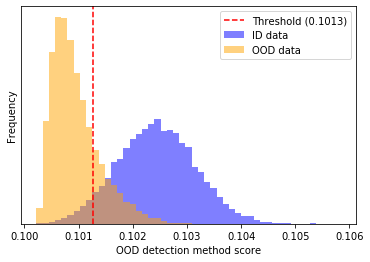

In [11]:
plot_hist(preds_id, preds_svhn, threshold)

AUROC: 0.9588077949999999


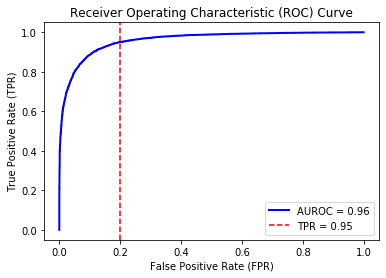

In [12]:
calc_auroc(preds_id, preds_svhn)

In [13]:
path_data = 'C:\\Users\\20203666\\Documents\\BEP\\code\\Representation_Learning\\data\\imagenet_test\\imagenet_data.pkl'
path_labels = 'C:\\Users\\20203666\\Documents\\BEP\\code\\Representation_Learning\\data\\imagenet_test\\imagenet_labels.pkl'

with open(path_data, 'rb') as file:
    # Load the data from the pickle file
    imagenet_data = pickle.load(file)

with open(path_labels, 'rb') as file:
    # Load the data from the pickle file
    imagenet_labels = pickle.load(file)


class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image and label to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        #label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label



normalize_transform_domain_shift = transforms.Compose([transforms.Normalize(mean_id, std_id)])

dataset_domain_shift = CustomDataset(imagenet_data, imagenet_labels, transform=normalize_transform_domain_shift)

loader_domain_shift = torch.utils.data.DataLoader(dataset_domain_shift
                                                  , batch_size=batch_size
                                                  , shuffle=False)
preds_domain_shift = predict_ODIN(neta, loader_domain_shift, epsilon, temperature,threshold)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [14]:
calc_FPR95(preds_domain_shift)

percentage ID: 0.9221, percentage accurate total: 0.7377, percentage accurate and ID: 0.6958, percentage accurate of ID: 0.7545819325452771


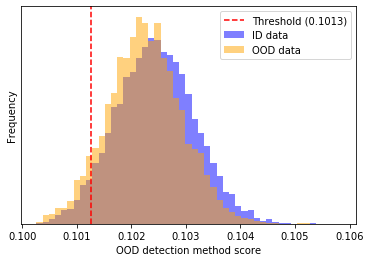

AUROC: 0.5768508349999999


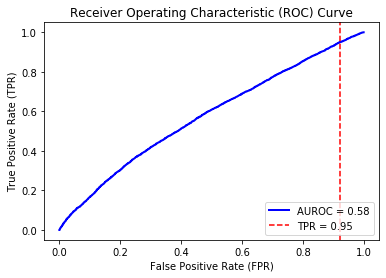

In [16]:
plot_hist(preds_id, preds_domain_shift, threshold)

calc_auroc(preds_id, preds_domain_shift)

In [17]:


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        # Add Gaussian noise to the tensor
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise

        # Clip pixel values to maintain range between 0 and 1
        noisy_tensor = torch.clamp(noisy_tensor, 0., 1.)
        return noisy_tensor


noise_level = 0.075

# Define normalization transformation
normalize_transform_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=noise_level),
    transforms.Normalize(mean_id, std_id)])


dataset_noise = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_noise)

loader_noise = torch.utils.data.DataLoader(dataset_noise
                                           , batch_size=batch_size
                                           , shuffle=False)

preds_noise = predict_ODIN(neta, loader_noise, epsilon, temperature,threshold)

Files already downloaded and verified


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [18]:
calc_FPR95(preds_noise)

percentage ID: 0.9987, percentage accurate total: 0.4375, percentage accurate and ID: 0.4373, percentage accurate of ID: 0.4378692299989987


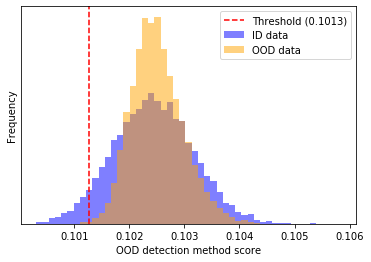

AUROC: 0.46987670000000004


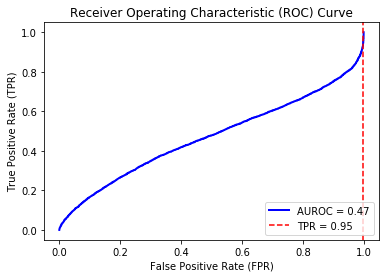

In [19]:
plot_hist(preds_id, preds_noise, threshold) #0.025
calc_auroc(preds_id, preds_noise)

In [20]:


class AddBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        pil_img = transforms.ToPILImage()(img)  # Convert Tensor to PIL Image
        blurred_img = pil_img.filter(ImageFilter.GaussianBlur(radius=self.radius))  # Apply Gaussian blur
        return transforms.ToTensor()(blurred_img)

blur_level = 1

# Define normalization transformation
normalize_transform_blur = transforms.Compose([
    transforms.ToTensor(),
    AddBlur(radius=blur_level),
    transforms.Normalize(mean_id, std_id)])


dataset_blur = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_blur)

loader_blur = torch.utils.data.DataLoader(dataset_blur
                                          , batch_size=batch_size
                                          , shuffle=False)
preds_blur = predict_ODIN(neta, loader_blur, epsilon, temperature,threshold)

Files already downloaded and verified


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [21]:
calc_FPR95(preds_blur)

percentage ID: 0.4083, percentage accurate total: 0.4381, percentage accurate and ID: 0.2355, percentage accurate of ID: 0.5767817781043351


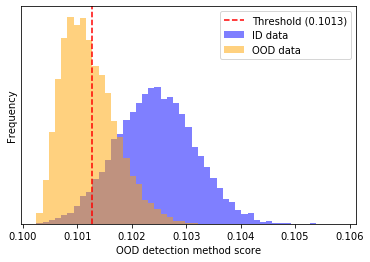

AUROC: 0.9190039400000001


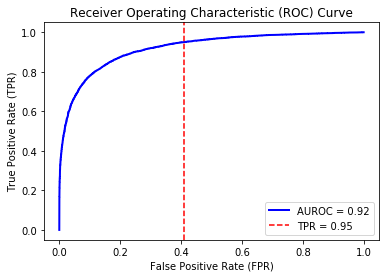

In [22]:
plot_hist(preds_id, preds_blur, threshold) #0.075
calc_auroc(preds_id, preds_blur)

In [24]:


# FGSM attack to generate adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


# Custom transformation to apply FGSM attack
class AdversarialAttack(object):
    def __init__(self, model, epsilon=0.1):
        self.epsilon = epsilon
        self.model = model

    def __call__(self, img):
        criterion = torch.nn.CrossEntropyLoss().cuda()
        input = Variable(img.cuda(), requires_grad=True)
        output = self.model(input.unsqueeze(0))  # Assuming 'model' is your trained model
        _, pred = output.max(1)
        loss = criterion(output, pred)
        loss.backward()
        data_grad = input.grad.data
        perturbed_img = fgsm_attack(input, self.epsilon, data_grad)
        perturbed_img = perturbed_img.squeeze(0)
        perturbed_img = perturbed_img.to('cpu')
        perturbed_img = perturbed_img.detach()
        return perturbed_img


attack_level = 0.15

# Define normalization transformation
normalize_transform_adversarial = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id),
    AdversarialAttack(model=neta, epsilon=attack_level)])


dataset_adversarial = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_adversarial)

loader_adversarial = torch.utils.data.DataLoader(dataset_adversarial
                                                 , batch_size=batch_size
                                                 , shuffle=False)
preds_adversarial = predict_ODIN(neta, loader_adversarial, epsilon, temperature,threshold)

Files already downloaded and verified


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


In [25]:
calc_FPR95(preds_adversarial)

percentage ID: 0.9945, percentage accurate total: 0.0849, percentage accurate and ID: 0.0845, percentage accurate of ID: 0.08496732026143791


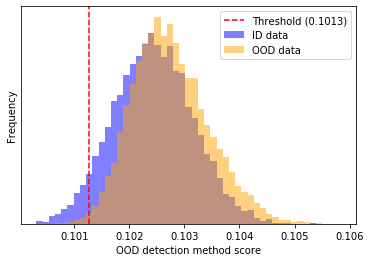

AUROC: 0.38426327499999996


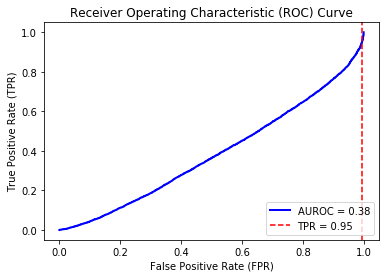

In [26]:
plot_hist(preds_id, preds_adversarial, threshold) #0.075
calc_auroc(preds_id, preds_adversarial)

Files already downloaded and verified


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
percentage ID: 0.91

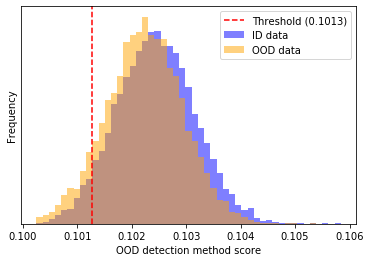

AUROC: 0.57876021


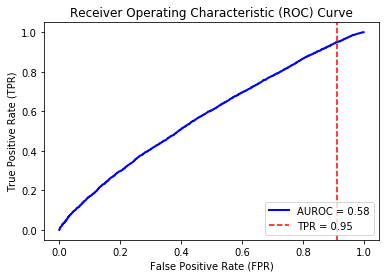

In [23]:
class AddBrightness(object):
    def __init__(self, brightness=1, contrast=1, saturation=1, hue=0, randomhue=False):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.randomhue = randomhue
    def __call__(self, img):

        # Apply color shift deterministically
        img = FT.adjust_brightness(img, self.brightness)
        img = FT.adjust_contrast(img, self.contrast)
        img = FT.adjust_saturation(img, self.saturation)
        img = FT.adjust_hue(img, self.hue)
        if self.randomhue==True:
            random_number = 0  # Initialize with 5 to start the loop
            while random_number == 0 :
                random_number = random.randint(1, 10)
                random_number = (random_number-5)/10
            img = FT.adjust_hue(img, random_number)
        return img
normalize_transform_bright = transforms.Compose([
    transforms.ToTensor(),
    AddBrightness(brightness=1.75),
    transforms.Normalize(mean_id, std_id)])


dataset_bright = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_bright)

loader_bright = torch.utils.data.DataLoader(dataset_bright
                                            , batch_size=batch_size
                                            , shuffle=False)
preds_bright= predict_ODIN(neta, loader_bright, epsilon, temperature,threshold)
calc_FPR95(preds_bright)
plot_hist(preds_id, preds_bright, threshold)  #0.075
calc_auroc(preds_id, preds_bright)